# Most Streamed Spotify Songs 2024 EDA


In [24]:
#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv("/Users/mani/Desktop/eda/data/Most Streamed Spotify Songs 2024.csv", encoding='latin1')

In [26]:
# Initial Data Exploration
df.info()
print('\n------ Percentage null ------\n')
print(df.isnull().sum() / len(df) * 100)
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Track                       4600 non-null   object 
 1   Album Name                  4600 non-null   object 
 2   Artist                      4595 non-null   object 
 3   Release Date                4600 non-null   object 
 4   ISRC                        4600 non-null   object 
 5   All Time Rank               4600 non-null   object 
 6   Track Score                 4600 non-null   float64
 7   Spotify Streams             4487 non-null   object 
 8   Spotify Playlist Count      4530 non-null   object 
 9   Spotify Playlist Reach      4528 non-null   object 
 10  Spotify Popularity          3796 non-null   float64
 11  YouTube Views               4292 non-null   object 
 12  YouTube Likes               4285 non-null   object 
 13  TikTok Posts                3427 

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0


## Data Cleaning & Numeric Conversion


In [27]:
# Drop completely null column
df = df.drop(columns=['TIDAL Popularity'], errors='ignore')

# Columns to convert from string to numeric
platform_cols = [
    'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity',
    'YouTube Views', 'YouTube Likes', 'YouTube Playlist Reach',
    'TikTok Posts', 'TikTok Likes', 'TikTok Views',
    'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
    'Deezer Playlist Count', 'Deezer Playlist Reach',
    'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
    'Soundcloud Streams', 'Shazam Counts'
]

# Remove commas, convert to numeric
for col in platform_cols:
    df[col] = df[col].astype(str).str.replace(',', '').replace('nan', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Summary statistics
summary = df[platform_cols].describe().transpose()
print(summary[['count', 'mean', 'min', 'max']])

                             count          mean     min           max
Spotify Streams             4487.0  4.473873e+08  1071.0  4.281469e+09
Spotify Playlist Count      4530.0  5.939083e+04     1.0  5.903920e+05
Spotify Playlist Reach      4528.0  2.334682e+07     1.0  2.623434e+08
Spotify Popularity          3796.0  6.350158e+01     1.0  9.600000e+01
YouTube Views               4292.0  4.027967e+08   913.0  1.632276e+10
YouTube Likes               4285.0  2.930049e+06    25.0  6.231118e+07
YouTube Playlist Reach      3591.0  3.439601e+08     1.0  7.289707e+09
TikTok Posts                3427.0  9.443076e+05     1.0  4.290000e+07
TikTok Likes                3620.0  1.126375e+08     3.0  2.347422e+10
TikTok Views                3619.0  1.161158e+09    19.0  2.332323e+11
Apple Music Playlist Count  4039.0  5.460312e+01     1.0  8.590000e+02
AirPlay Spins               4102.0  5.513916e+04     1.0  1.777811e+06
SiriusXM Spins              2477.0  2.573444e+02     1.0  7.098000e+03
Deezer

## Distributions of Key Metrics


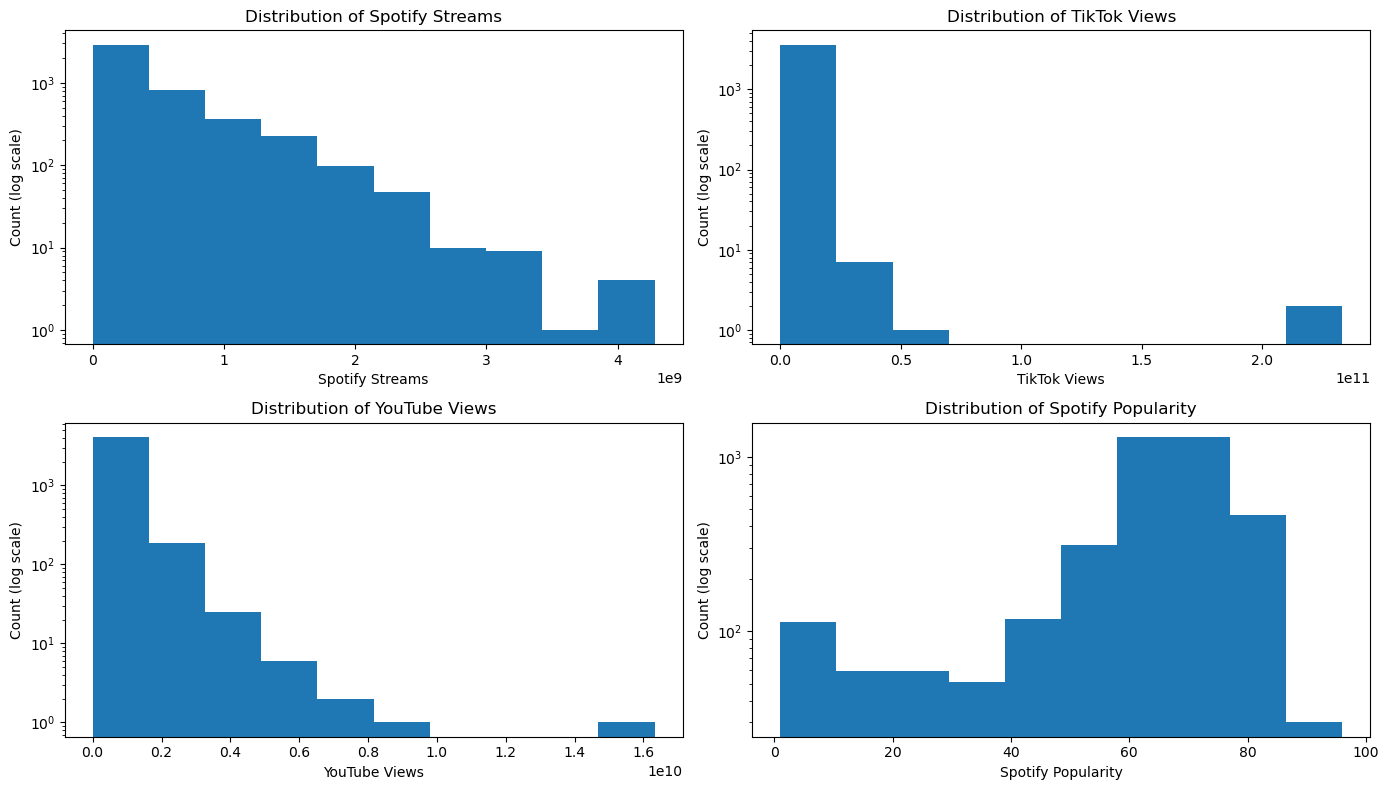

In [28]:
cols_to_plot = ['Spotify Streams', 'TikTok Views', 'YouTube Views', 'Spotify Popularity']
plt.figure(figsize=(14, 8))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[col].dropna(), log=True)
    plt.xlabel(col)
    plt.ylabel('Count (log scale)')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

#### Insights:

- Spotify Streams, TiKTok Views, and YouTube Views seem pretty heavily right skewed, especially TikTok views. This indicating that most views/streams tend to be lower, except for the few viral videos in the tail.
- Spotify Popularity though looks more normal, with a slight right skew.


## Correlations and Cross-Platform Relationships


In [35]:
corr_cols = ['Spotify Streams', 'TikTok Views', 'YouTube Views', 'Spotify Popularity', 'Spotify Playlist Count']
corr_matrix = df[corr_cols].corr()
print("Correlation Matrix:")
corr_matrix

Correlation Matrix:


,Spotify Streams,TikTok Views,YouTube Views,Spotify Popularity,Spotify Playlist Count
Spotify Streams,1.000000,0.030481,0.468619,0.359931,0.815083
TikTok Views,0.030481,1.000000,0.003535,-0.059513,0.035026
YouTube Views,0.468619,0.003535,1.000000,0.035983,0.322035
Spotify Popularity,0.359931,-0.059513,0.035983,1.000000,0.390597
Spotify Playlist Count,0.815083,0.035026,0.322035,0.390597,1.000000


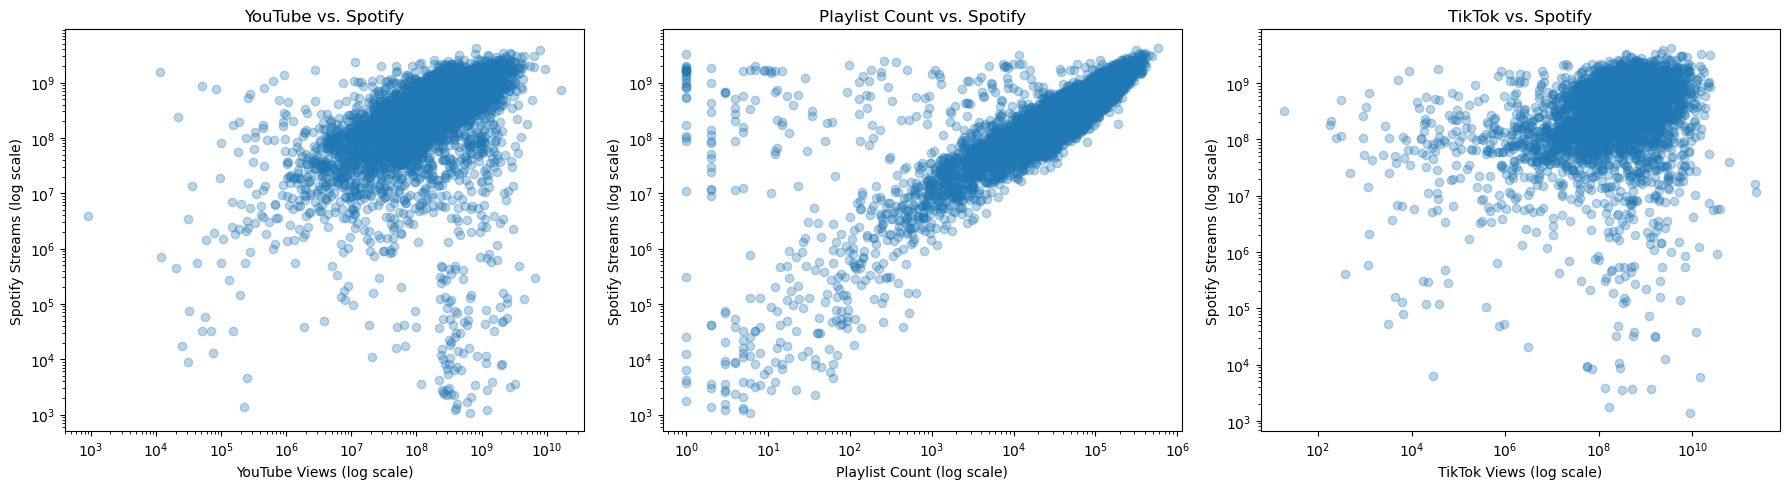

Correlation (YouTube vs Spotify): 0.46861947673925397
Correlation (Playlist Count vs Spotify): 0.815083269042
Correlation (TikTok vs Spotify): 0.030480769513023316


In [40]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: YouTube vs Spotify
axs[0].scatter(df['YouTube Views'], df['Spotify Streams'], alpha=0.3)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('YouTube Views (log scale)')
axs[0].set_ylabel('Spotify Streams (log scale)')
axs[0].set_title('YouTube vs. Spotify')
yt_corr = df['YouTube Views'].corr(df['Spotify Streams'])

# Plot 2: Playlist Count vs Spotify
axs[1].scatter(df['Spotify Playlist Count'], df['Spotify Streams'], alpha=0.3)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Playlist Count (log scale)')
axs[1].set_ylabel('Spotify Streams (log scale)')
axs[1].set_title('Playlist Count vs. Spotify')
pl_corr = df['Spotify Playlist Count'].corr(df['Spotify Streams'])

# Plot 3: TikTok vs Spotify
axs[2].scatter(df['TikTok Views'], df['Spotify Streams'], alpha=0.3)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('TikTok Views (log scale)')
axs[2].set_ylabel('Spotify Streams (log scale)')
axs[2].set_title('TikTok vs. Spotify')
tt_corr = df['TikTok Views'].corr(df['Spotify Streams'])

plt.tight_layout()
plt.show()

# Print all correlations
print("Correlation (YouTube vs Spotify):", yt_corr)
print("Correlation (Playlist Count vs Spotify):", pl_corr)
print("Correlation (TikTok vs Spotify):", tt_corr)


#### Insights:

- Surprisingly, TiTok Views and Spotify Streams has a low correlation! Meaning a viral TikTok video doesn't mean the song will necessarily do well.
- YouTube Views seem to have more of a correlation. This could be due to music video watches.
- Spotify Playlist count has the largest correlation of 0.815.


## Outliers


Since YouTube Views is positively correlated with Spotify Streams, let's see if there are any songs that might be popular on Youtube but aren't streamed much on Spotify.


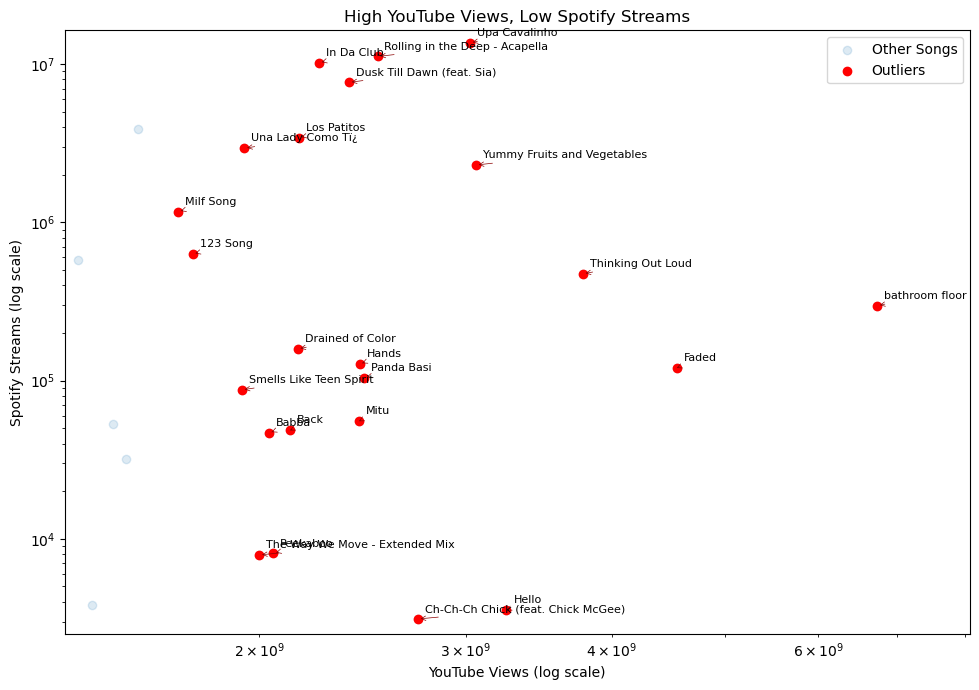

Songs with High YouTube Views and Low Spotify Streams:


,Track,Artist,YouTube Views,Spotify Streams
14,bathroom floor,Kids With Buns,6.736502e+09,297185.0
51,Panda Basi,Mvua,2.457027e+09,104271.0
54,Mitu,Maian,2.432266e+09,55346.0
69,Babba,Guy Mac,2.038460e+09,46567.0
73,The Way We Move - Extended Mix,PowerDress,1.999374e+09,7909.0
82,Peekaboo,Dave Angel,2.055941e+09,8082.0
115,Hands,Dianï¿½,2.435814e+09,126914.0
128,Drained of Color,Exhumed,2.156141e+09,158627.0
139,Back,LOLA,2.123978e+09,48428.0
215,Milf Song,The Puddleducks,1.704937e+09,1165982.0


In [41]:
# Identify outliers: High YouTube Views & Low Spotify Streams
q95_youtube = df['YouTube Views'].quantile(0.95)
q10_spotify = df['Spotify Streams'].quantile(0.10)

outliers = df[(df['YouTube Views'] > q95_youtube) & (df['Spotify Streams'] < q10_spotify)]

# Plot with highlights
plt.figure(figsize=(10, 7))
plt.scatter(df['YouTube Views'], df['Spotify Streams'], alpha=0.15, label='Other Songs')
plt.scatter(outliers['YouTube Views'], outliers['Spotify Streams'], color='red', label='Outliers')

plt.xscale('log'); plt.yscale('log')
plt.xlabel('YouTube Views (log scale)')
plt.ylabel('Spotify Streams (log scale)')
plt.title('High YouTube Views, Low Spotify Streams')
plt.xlim(outliers['YouTube Views'].min() * 0.8, outliers['YouTube Views'].max() * 1.2)
plt.ylim(outliers['Spotify Streams'].min() * 0.8, outliers['Spotify Streams'].max() * 1.2)

# Annotate outliers
for i, row in outliers.iterrows():
    plt.annotate(row['Track'], (row['YouTube Views'], row['Spotify Streams']),
                 xytext=(5, 5), textcoords="offset points", fontsize=8,
                 arrowprops=dict(arrowstyle='->', lw=0.5, color='darkred'))

plt.legend()
plt.tight_layout()
plt.show()

# Display selected outliers
print("Songs with High YouTube Views and Low Spotify Streams:")
outliers[['Track', 'Artist', 'YouTube Views', 'Spotify Streams']]

#### Insights:

Spotify could advertise these songs on their platform/algorithm. Success on YouTube may be a good indicator of success on Spotify based on their correlation.
